# SaxaVord EO Challenge

Welcome to your challenge: Focussing on an Area of Interest (AOI) over the Faroe Islands, you can look at either: 

* Quantify the extent of algae bloom changes, and their impact on nearby Salmon Fishing Farms
* Quantify the extent of recent coastal erosion 

## Check Environment Active

In [ ]:
# Desktop UI:
# It should also show this on the top RHS of your screen, below the LogOut button

In [ ]:
# Conda
#  -- Activate environment will show a '*' next to it
!conda env list

In [ ]:
# Pip
# TODO: Add this for pip !pip XYZ

## Import Packages

In [7]:
# Packages
import os
import glob

import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile


In [8]:
# Visualisation Params
%matplotlib inline    # plots images in the Jupyter notebook cells
%matplotlib qt5       # opens a seperate browser window to view images

UsageError: unrecognized arguments: # plots images in the Jupyter notebook cells


# Sentinel 2

### The Data Folder Structure
Satellite imagery products are folders which contain satellite imagery data in a standardised way, including standard naming conventions for folders etc. Please see the SaxaVord PDF for an explanation of the Sentinel 2 naming convention. 

A single image  product of a region at DateTime YYYYMMDD-HHMMSS is packaged in a folder with a hierarchical file structure. In our case this is:

    |- S2A_MSIL2A_20220531T120411_N0400_R066_T30VUQ_20220531T183212 *folder for a single day-time image product*
        |-S2A_MSIL2A_20220531T120411_N0400_R066_T30VUQ_20220531T183212.SAFE
            |-GRANULE
                |-L2A_T30VUQ_A036242_20220531T120405
                    |-IMG_DATA
                        |- R10m  *resolution folders*
                            |-T30VUQ_20220531T120411_B02_10m.jp2 *individual band file*
                            |-T30VUQ_20220531T120411_B03_10m.jp2
                            |-...
                            |-T30VUQ_20220531T120411_TCI_10m.jp2 *TCI = true color image, multi-band file *

                        |- R20m
                            |-T30VUQ_20220531T120411_B02_20m.jp2
                            |-T30VUQ_20220531T120411_B03_20m.jp2
                            |-...
                        |- R60m
                            |-T30VUQ_20220531T120411_B02_60m.jp2
                            |-T30VUQ_20220531T120411_B03_60m.jp2
                            |-...


### Image Bands
* True Colour Images (RGB) are comprised of 3 bands, Red, Green and Blue - the visible light section of the Electromagnetic Spectrum. 

* Satellite sensors cover a far broader section of this spectrum, and therefore capture a larger number of bands. 

* Different phenomena on earth and within the atmosphere react differently to wavelengths across the spectrum (e.g. different bands), allowing us to make inferences about what is occuring below.

* Certain bands are therefore useful for different environmental analyses.


### Working with This Data
For our data we have:
* Images for a set of dates throughout time
* Each image has multiple bands in multiple resolutions
* The filepath for each band is going to be very verbose and difficult to track due to the hierarchical structure

To make all these paths easier to work with, we shall give each Image into it's own dictionary and store all filepaths there. This will enable easy referencing. The code below creates these dictionaries for you.

```
img_band_dict = {
                'img_folder': 'S2A_MSIL2A_20220531T120411_N0400_R066_T30VUQ_20220531T183212',

                 'img_date': '20220531',
                 'img_time': '183212',
                 
                 'R10m':{'B02': 'T30VUQ_20220531T120411_B02_10m.jp2',
                         'B03': 'T30VUQ_20220531T120411_B03_10m.jp2',
                         ...
                         'TCI': 'T30VUQ_20220531T120411_TCI_10m.jp2'
                        },
                        
                  'R20m':{'B02': 'T30VUQ_20220531T120411_B02_20m.jp2',
                          'B03': 'T30VUQ_20220531T120411_B03_20m.jp2',
                           ...
                          },
                          
                  'R60m':{'B02': 'T30VUQ_20220531T120411_B02_60m.jp2',
                          'B03': 'T30VUQ_20220531T120411_B03_60m.jp2',
                           ...
                          }
                 }
                 
```
                 

**For Example:** To create a True Colour Image (RGB) at 10m resolution, we use Red (B04), Green (B03), Blue (B02). The individual bands can then be accessed:

```
## 10m resolution:
r_10m_filepath = img_band_dict['R10m']['B04']
r_10m_band_img = get_band(r_10m_filepath)

g_10m_filepath = img_band_dict['R10m']['B03']
g_10m_band_img = get_band(g_10m_filepath)

b_10m_filepath = img_band_dict['R10m']['B02']
b_10m_band_img = get_band(b_10m_filepath)
```

## Zipped Image Folders: Rename & Extract All Data

In [13]:
# Function to extract source folder.zip to targer folder
def extract_from_zip(source, target):
    with ZipFile(source, 'r') as zip_ref:
        zip_ref.extractall(target)     

In [14]:
# Path from notebook to folder containing zipped folder for each day's data
s2_imgs_folder = 'Faroe Islands Satellite Data'

# Select your joiner 
# MAC 
jn = '/'

# WINDOWS
jn = '\\'


# Windows: Zip Folder names may be too long upon extraction, shorten names by removing characters from name from '_N0400' onwards
for file_name in os.listdir(s2_imgs_folder):
    file = ''
    file = s2_imgs_folder + jn + file_name #TODO: switch '\\' to '/' for Mac
    
    # Only perform operation of zipped folders
    if file.endswith('.zip'):
        t = '_N0400'
        ind = file.find(t)
        
        # Renaming required
        if ind>=0:    
            file_new = file[:ind] + '.zip'
            os.rename(file, file_new)

        # No renaming required
        else:
            file_new = file
            
        # Extract all files from .zip
        file_new_unzip = file_new[:-4]
        extract_from_zip(file_new, file_new_unzip)
        
             
# Check name shortened, and folders unzipped correctly        
os.listdir(s2_imgs_folder)

['S2A_MSIL2A_20220531T120411',
 'S2A_MSIL2A_20220531T120411.zip',
 'S2A_MSIL2A_20220607T115411',
 'S2A_MSIL2A_20220607T115411.zip',
 'S2B_MSIL2A_20220327T120359',
 'S2B_MSIL2A_20220327T120359.zip',
 'S2B_MSIL2A_20220419T121349',
 'S2B_MSIL2A_20220419T121349.zip',
 'S2B_MSIL2A_20220705T120359',
 'S2B_MSIL2A_20220705T120359.zip',
 'S2B_MSIL2A_20220831T115359',
 'S2B_MSIL2A_20220831T115359.zip']

## Create Dictionaries of Band File Paths

In [15]:
# Get list of unzipped folders
lst = os.listdir(s2_imgs_folder)

unzipped_img_folders = [x for x in lst if x.endswith('.zip')==False]

unzipped_img_folders


['S2A_MSIL2A_20220531T120411',
 'S2A_MSIL2A_20220607T115411',
 'S2B_MSIL2A_20220327T120359',
 'S2B_MSIL2A_20220419T121349',
 'S2B_MSIL2A_20220705T120359',
 'S2B_MSIL2A_20220831T115359']

In [16]:
# For each unzipped folder (a single day product), go in & extract all '.jp2' filepaths for the bands into a dictionary
# Store all dictionaries in a list (all_img_dicts)

all_img_dicts = []

for img_folder in unzipped_img_folders:

    ## List all band filenames
#     img_folder = 'S2B_MSIL2A_20220419T121349'
    date = img_folder[11:19]
    time = img_folder[20:28]
    f = s2_imgs_folder + jn + img_folder + jn

    # Sub-folders containing band data
    res_set = ['R10m', 'R20m', 'R60m']

    # Create a dictionary of the band names
    bands = ['B01','B02','B03','B04','B05','B06', 'B07','B08', 'B8A', 'B09' ,'B10','B11','B12', 'AOT','TCI','WVP', 'SCL']

    all_band_files = [ x for x in glob.glob(f + '**\*', recursive=True) if any(res in x for res in res_set) and x.endswith('jp2')]


    img_band_dict = {'img_folder':img_folder,
                     'img_date':date,
                     'img_time':time}

    # Create a key for each resolution
    for res in res_set:
        img_band_dict[res] = {}

    # Assign all band filepaths to dict
    for band_file in all_band_files:

        # For each resolution, get all band filepaths
        for res in res_set:

            # Band file is in the resolution folder (contains res = 'R10m')
            if band_file.find(res)>=0:

                # Get the band type (B08, B8A, TCI etc)
                band_type = band_file[len(band_file)-11:-8]

                # Store e.g. img_band_dict['R10m']['B03'] = 'filepath/to/R10m/img_B03.jp2'
                img_band_dict[res][band_type] = band_file
                
    
    all_img_dicts.append(img_band_dict)
            

In [17]:
# all_img_dicts

In [30]:
# Access a dictionary of a single image
single_img_dict = all_img_dicts[0]

print('date:',single_img_dict['img_date'])
print('time:',single_img_dict['img_time'])

print('path to 20m B05 Band (Red Edge):')
print('   ', single_img_dict['R20m']['B05'])

date: 20220531
time: 120411
path to 20m B05 Band (Red Edge):
    Faroe Islands Satellite Data\S2A_MSIL2A_20220531T120411\S2A_MSIL2A_20220531T120411_N0400_R066_T30VUQ_20220531T183212.SAFE\GRANULE\L2A_T30VUQ_A036242_20220531T120405\IMG_DATA\R20m\T30VUQ_20220531T120411_B05_20m.jp2


## Import Band Data

The single band files (B02, B03, B04,...) are 2D rasters. These are 2D numpy arrays with some associated metadata. 
The composite band files e.g. TCI are 3D rasters. 

In general, **rasterio** (rio) can be used to import rasters.

Note that rasterio takes the top Left Hand Side of your array as (0,0), then x is the rows downwards, and y is the columns right

In [ ]:

## Perform calcs

In [35]:
## Extract Single Band into an Array

def get_band(filepath): 
    with rio.open(filepath) as f:
        
        print('Extracting single band from file')
        band_img = f.read(1, masked=True)
        
        print('Extracting band meta')
        band_img_meta = f.profile
        
        print('--> # bands:', band_img_meta['count'])
        print('--> datatype:', band_img_meta['dtype'])
        print('--> nodata:', band_img_meta['nodata'])
        print('--> height:', band_img_meta['height'])
        print('--> width:', band_img_meta['width'])
        
        return band_img     
    
        
test_img = get_band(img_band_dict['R10m']['B02'])



Extracting single band from file
Extracting band meta
--> # bands: 1
--> datatype: uint16
--> nodata: None
--> height: 10980
--> width: 10980


In [36]:
type(band_img) ## object returned (MaskedArray = Special type of numpy array  => nunpy methods apply easily!)

numpy.ma.core.MaskedArray

In [37]:
band_img.shape ## 2D array

(10980, 10980)

(array([1.01018776e+08, 4.44545000e+06, 1.04332400e+06, 3.87383300e+06,
        9.66658000e+06, 5.11288000e+05, 6.66000000e+02, 2.71000000e+02,
        1.57000000e+02, 5.50000000e+01]),
 array([    0. ,  1681.6,  3363.2,  5044.8,  6726.4,  8408. , 10089.6,
        11771.2, 13452.8, 15134.4, 16816. ]),
 <BarContainer object of 10 artists>)

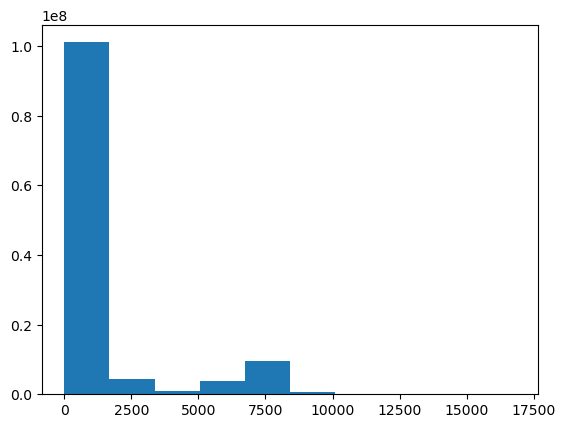

In [38]:
# Understanding distn of pixel values
plt.hist(band_img.flatten())   

**Notice above:** For RGB, integer pixel values take values [0,255], yet above its far higher. Why?

* **Traditional RGB pixels have 8-Bit Depth:** Each channel has 256 shades, so for RGB there are 256x256x256 colours. Often encoded as datatype uint8.
* **Satellites tend to have a larger Bit Depth (12 or 16):** These will be encoded as uint16, and can be seen in the metadata printouts above

**Why do we care?**
It is better to convert 


In [116]:
## Extract individual bands

## 10m picture 
b10 = img_band_dict['R10m']['B02']
g10 = img_band_dict['R10m']['B03']
r10 = img_band_dict['R10m']['B04']
n10 = img_band_dict['R10m']['B08']


# 20m picture
img_band_dict['R20m'].keys()



# 60m picture
img_band_dict['R60m'].keys()

dict_keys(['AOT', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B09', 'B11', 'B12', 'B8A', 'SCL', 'TCI', 'WVP'])

In [105]:
## Example of extracting TCI (RGB) image 

# with rasterio.open(img_band_dict['R10m']['TCI']) as f:
#     # Extract the band array (single array only = 1)
#     print('Number of bands in file:',f.profile['count'])
    
#     band_img = f.read([1,2,3], masked=True)
    

Number of bands in file: 3


In [ ]:
## Create a 3-band raster (under the hood, this is a numpy ndarray)

print('Creating Raster')
rgb_10 = np.dstack([r10,g10,b10])

print('Check datatype')
# Bit depth

## Visualisation

In [ ]:
## Plot raster

## Bit conversion if out of range